# Training prediction models (per serving)

Use pre-trained DenseNet121 model as backbone model.

Add Imagenet preprocessing to the first layer

Five models: calorie, calorie+ingredient, calorie+category, calorie+nutrient, calorie+3 vectors

In [ ]:
import ast
import pickle
import pandas as pd

In [1]:
from tensorflow import config

gpu_devices = config.experimental.list_physical_devices('GPU')

for device in gpu_devices: config.experimental.set_memory_growth(device, True)

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Load preprocessed csv file

In [2]:
train_data = pd.read_csv('./data/train_per_serving_complete.csv')

# transform format from string to list 
train_data['category_vector'] = train_data['category_vector'].apply(ast.literal_eval)
train_data['nutrient_vector'] = train_data['nutrient_vector'].apply(ast.literal_eval)
train_data['ingredient_vector'] = train_data['ingredient_vector'].apply(ast.literal_eval)

print(len(train_data))
train_data.head()

6457


,title,image,ingredients,nutrients,file_name,category,serving,url,source,calorie,category_vector,parsed_ingredients,ingredient_vector,nutrient_vector
0,Easy bread rolls,https://images.immediate.co.uk/production/vola...,"['500g strong white bread flour , plus extra f...","{'calories': '246 calories', 'fatContent': '2 ...",bread0.jpg,bread,8.0,https://www.bbcgoodfood.com/recipes/Easy-bread...,bbc,246,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","['bread flour', 'action yeast', 'caster sugar'...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[2.0, 48.0, 8.0]"
1,Vegan banana bread,https://images.immediate.co.uk/production/vola...,"['3 large black bananas', '75ml vegetable oil ...","{'calories': '218 calories', 'fatContent': '8 ...",bread1.jpg,bread,10.0,https://www.bbcgoodfood.com/recipes/Vegan-bana...,bbc,218,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","['black banana', 'sunflower oil', 'brown sugar...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[8.0, 33.0, 3.0]"
2,Meatball & garlic bread traybake,https://images.immediate.co.uk/production/vola...,"['350g turkey thigh mince', '1 tsp dried orega...","{'calories': '565 calories', 'fatContent': '28...",bread2.jpg,bread,3.0,https://www.bbcgoodfood.com/recipes/Meatball-&...,bbc,565,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","['thigh mince', 'tsp oregano', 'fennel seed', ...","[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[28.0, 34.0, 42.0]"
3,Naan bread,https://images.immediate.co.uk/production/vola...,"['1x 7g sachet dried yeast', '2 tsp golden cas...","{'calories': '224 calories', 'fatContent': '8 ...",bread3.jpg,bread,8.0,https://www.bbcgoodfood.com/recipes/Naan-bread,bbc,224,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","['sachet yeast', 'caster sugar', 'bread flour'...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[8.0, 31.0, 6.0]"
4,Pitta bread,https://images.immediate.co.uk/production/vola...,"['2 tsp fast-action dried yeast', '500g strong...","{'calories': '246 calories', 'fatContent': '2 ...",bread4.jpg,bread,8.0,https://www.bbcgoodfood.com/recipes/Pitta-bread,bbc,246,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","['fastaction yeast', 'bread flour', 'tsp salt'...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.0, 47.0, 8.0]"


## Build network

Add imagenet preprocessing as the first layer.

use Densenet121 as the backbone model.

define multi-outputs with corresponding activation functions to help improve the accurcy of calorie(y).

In [3]:
# do not mix tensorflow and keras...
# https://stackoverflow.com/questions/51821537/attributeerror-node-object-has-no-attribute-output-masks


import tensorflow as tf

i = tf.keras.layers.Input([256, 256, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = tf.keras.applications.densenet.preprocess_input(x)
core = tf.keras.applications.densenet.DenseNet121(weights='imagenet', include_top=False)

x = core(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
y = tf.keras.layers.Dense(1, activation = "relu", name='calorie')(x)
y1 = tf.keras.layers.Dense(12, activation = "softmax", name='category_vector')(x)
y2 = tf.keras.layers.Dense(3, activation = "relu", name='nutrient_vector')(x)
y3 = tf.keras.layers.Dense(100, activation = "sigmoid", name='ingredient_vector')(x)

model = tf.keras.models.Model(inputs=[i], outputs=[y, y1, y2, y3])

for l in model.layers:
    l.trainable = False
for l in model.layers[-7:]:
    l.trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 256, 256, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 256, 256, 3) 0           tf_op_layer_Cast[0][0]           
__________________________________________________________________________________________________
tf_op_layer_BiasAdd (TensorFlow [(None, 256, 256, 3) 0           tf_op_layer_truediv[0][0]        
______________________________________________________________________________________________

In [4]:
model.output

[<tf.Tensor 'calorie/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'category_vector/Identity:0' shape=(None, 12) dtype=float32>,
 <tf.Tensor 'nutrient_vector/Identity:0' shape=(None, 3) dtype=float32>,
 <tf.Tensor 'ingredient_vector/Identity:0' shape=(None, 100) dtype=float32>]

## Train multi-task models (per serving)

### 5. output: calorie + three vectors

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    #rescale=1/255, 
    validation_split=0.2, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    )

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie', 'category_vector', 'nutrient_vector', 'ingredient_vector'],
    batch_size=128,
    shuffle=True,
    subset='training',
    class_mode='multi_output')

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie', 'category_vector', 'nutrient_vector', 'ingredient_vector'],
    batch_size=128,
    shuffle=True,
    subset='validation',
    class_mode='multi_output')
    #validate_filenames=False)

Found 5160 validated image filenames.
Found 1290 validated image filenames.


/home/uceezku/project/lib64/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 7 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

model.compile(optimizer=Adam(lr=1e-3), loss={'calorie':'mse', 'ingredient_vector':'binary_crossentropy',
                                             'category_vector':'categorical_crossentropy', 'nutrient_vector':'mse'}
                                              , metrics=['mse'])

checkpointer = ModelCheckpoint(filepath='./multi-output/serving_three_vector_50epoch.h5', verbose=1, 
                               monitor='val_calorie_loss', mode='auto', save_best_only=True)

history = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=round(train_generator.n/train_generator.batch_size),
                    epochs=50,
                    validation_data=valid_generator,
                    validation_steps=round(valid_generator.n/valid_generator.batch_size),
                    callbacks=[checkpointer]
                   ) 

# save model and history
with open('./multi-output/serving_three_vector_50epoch.pkl','wb') as f:
    pickle.dump(history.history, f) 


Instructions for updating:
Please use Model.fit, which supports generators.
Train for 40 steps, validate for 10 steps
Epoch 1/50
10/40 [======>.......................] - ETA: 1:28 - loss: 138787.2719 - calorie_loss: 137980.2656 - category_vector_loss: 3.2014 - nutrient_vector_loss: 803.0588 - ingredient_vector_loss: 0.7465 - calorie_mse: 137980.2656 - category_vector_mse: 0.0875 - nutrient_vector_mse: 803.0588 - ingredient_vector_mse: 0.2449

/home/uceezku/project/lib64/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


39/40 [============================>.] - ETA: 2s - loss: 90159.9823 - calorie_loss: 89355.6562 - category_vector_loss: 6.8668 - nutrient_vector_loss: 796.8366 - ingredient_vector_loss: 0.6255 - calorie_mse: 88511.1484 - category_vector_mse: 0.1123 - nutrient_vector_mse: 796.0690 - ingredient_vector_mse: 0.1207
Epoch 00001: val_calorie_loss improved from inf to 41773.00000, saving model to ./multi-output/serving_three_vector_50epoch.h5
40/40 [==============================] - 124s 3s/step - loss: 88721.6833 - calorie_loss: 87947.8906 - category_vector_loss: 6.9885 - nutrient_vector_loss: 786.8717 - ingredient_vector_loss: 0.6265 - calorie_mse: 87100.2500 - category_vector_mse: 0.1126 - nutrient_vector_mse: 785.9494 - ingredient_vector_mse: 0.1195 - val_loss: 42095.4723 - val_calorie_loss: 41773.0000 - val_category_vector_loss: 5.8493 - val_nutrient_vector_loss: 315.9910 - val_ingredient_vector_loss: 0.6333 - val_calorie_mse: 41773.0000 - val_category_vector_mse: 0.0988 - val_nutrient_ve

Epoch 9/50
39/40 [============================>.] - ETA: 2s - loss: 20126.0885 - calorie_loss: 19586.9688 - category_vector_loss: 6.3433 - nutrient_vector_loss: 532.3362 - ingredient_vector_loss: 0.4398 - calorie_mse: 19595.1543 - category_vector_mse: 0.1148 - nutrient_vector_mse: 537.4596 - ingredient_vector_mse: 0.0689
Epoch 00009: val_calorie_loss improved from 23733.16406 to 23349.48047, saving model to ./multi-output/serving_three_vector_50epoch.h5
40/40 [==============================] - 119s 3s/step - loss: 20126.0205 - calorie_loss: 19592.6250 - category_vector_loss: 6.3157 - nutrient_vector_loss: 526.3253 - ingredient_vector_loss: 0.4387 - calorie_mse: 19600.6992 - category_vector_mse: 0.1148 - nutrient_vector_mse: 531.2133 - ingredient_vector_mse: 0.0687 - val_loss: 23658.3250 - val_calorie_loss: 23349.4805 - val_category_vector_loss: 7.8162 - val_nutrient_vector_loss: 300.6035 - val_ingredient_vector_loss: 0.4261 - val_calorie_mse: 23349.4805 - val_category_vector_mse: 0.079

Epoch 17/50
39/40 [============================>.] - ETA: 2s - loss: 18713.1284 - calorie_loss: 18210.9062 - category_vector_loss: 2.6828 - nutrient_vector_loss: 499.3139 - ingredient_vector_loss: 0.2257 - calorie_mse: 18211.2168 - category_vector_mse: 0.0781 - nutrient_vector_mse: 504.1137 - ingredient_vector_mse: 0.0502
Epoch 00017: val_calorie_loss did not improve from 22227.97266
40/40 [==============================] - 119s 3s/step - loss: 18750.2863 - calorie_loss: 18255.2246 - category_vector_loss: 2.6762 - nutrient_vector_loss: 492.0210 - ingredient_vector_loss: 0.2260 - calorie_mse: 18256.3027 - category_vector_mse: 0.0781 - nutrient_vector_mse: 496.5712 - ingredient_vector_mse: 0.0502 - val_loss: 22942.0252 - val_calorie_loss: 22632.3945 - val_category_vector_loss: 6.9138 - val_nutrient_vector_loss: 302.4370 - val_ingredient_vector_loss: 0.2808 - val_calorie_mse: 22632.3945 - val_category_vector_mse: 0.1030 - val_nutrient_vector_mse: 302.4370 - val_ingredient_vector_mse: 0.04

39/40 [============================>.] - ETA: 2s - loss: 17606.9125 - calorie_loss: 17125.6582 - category_vector_loss: 2.1883 - nutrient_vector_loss: 478.8799 - ingredient_vector_loss: 0.1848 - calorie_mse: 17136.4961 - category_vector_mse: 0.0716 - nutrient_vector_mse: 483.3886 - ingredient_vector_mse: 0.0454
Epoch 00033: val_calorie_loss did not improve from 22011.03320
40/40 [==============================] - 119s 3s/step - loss: 17560.4857 - calorie_loss: 17085.9160 - category_vector_loss: 2.1897 - nutrient_vector_loss: 471.8496 - ingredient_vector_loss: 0.1849 - calorie_mse: 17095.7812 - category_vector_mse: 0.0716 - nutrient_vector_mse: 476.1207 - ingredient_vector_mse: 0.0455 - val_loss: 26069.1016 - val_calorie_loss: 25746.9004 - val_category_vector_loss: 5.2007 - val_nutrient_vector_loss: 316.7769 - val_ingredient_vector_loss: 0.2245 - val_calorie_mse: 25746.9004 - val_category_vector_mse: 0.0945 - val_nutrient_vector_mse: 316.7769 - val_ingredient_vector_mse: 0.0485
Epoch 34/

39/40 [============================>.] - ETA: 2s - loss: 17526.5190 - calorie_loss: 17042.3613 - category_vector_loss: 2.1372 - nutrient_vector_loss: 481.8388 - ingredient_vector_loss: 0.1862 - calorie_mse: 17054.1230 - category_vector_mse: 0.0705 - nutrient_vector_mse: 486.6693 - ingredient_vector_mse: 0.0456
Epoch 00049: val_calorie_loss did not improve from 22011.03320
40/40 [==============================] - 118s 3s/step - loss: 17460.0633 - calorie_loss: 16983.0293 - category_vector_loss: 2.1382 - nutrient_vector_loss: 474.3460 - ingredient_vector_loss: 0.1864 - calorie_mse: 16993.4570 - category_vector_mse: 0.0706 - nutrient_vector_mse: 478.9225 - ingredient_vector_mse: 0.0457 - val_loss: 24759.0609 - val_calorie_loss: 24448.9062 - val_category_vector_loss: 4.3740 - val_nutrient_vector_loss: 305.5548 - val_ingredient_vector_loss: 0.2253 - val_calorie_mse: 24448.9062 - val_category_vector_mse: 0.0912 - val_nutrient_vector_mse: 305.5548 - val_ingredient_vector_mse: 0.0497
Epoch 50/

### 4. output: calorie+ingredient vector 

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    #rescale=1/255, 
    validation_split=0.2, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    )

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie', 'ingredient_vector'],
    batch_size=128,
    shuffle=True,
    subset='training',
    class_mode='multi_output')


valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie', 'ingredient_vector'],
    batch_size=128,
    shuffle=True,
    subset='validation',
    class_mode='multi_output')
    #validate_filenames=False)

Found 5196 validated image filenames.
Found 1298 validated image filenames.


/home/uceezku/project/lib64/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 7 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

model.compile(optimizer=Adam(lr=1e-3), loss={'calorie':'mse', 'ingredient_vector':'binary_crossentropy'}
              , metrics=['mse'])

checkpointer = ModelCheckpoint(filepath='./multi-output/ingredients/serving_ingredient_vector_50epoch.h5', verbose=1, 
                               monitor='val_calorie_loss', mode='auto', save_best_only=True)

history = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=round(train_generator.n/train_generator.batch_size),
                    epochs=50,
                    validation_data=valid_generator,
                    validation_steps=round(valid_generator.n/valid_generator.batch_size),
                    callbacks=[checkpointer]
                   ) 

with open('./multi-output/ingredients/serving_ingredient_vector_50epoch.pkl','wb') as f:
    pickle.dump(history.history, f) 


Instructions for updating:
Please use Model.fit, which supports generators.
Train for 41 steps, validate for 10 steps
Epoch 1/50
11/41 [=======>......................] - ETA: 1:22 - loss: 133570.9631 - calorie_loss: 133570.2656 - ingredient_vector_loss: 0.6876 - calorie_mse: 133427.3281 - ingredient_vector_mse: 0.2111

/home/uceezku/project/lib64/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


40/41 [============================>.] - ETA: 2s - loss: 84084.3833 - calorie_loss: 84083.7500 - ingredient_vector_loss: 0.6268 - calorie_mse: 83537.7578 - ingredient_vector_mse: 0.1110
Epoch 00001: val_calorie_loss improved from inf to 36669.50000, saving model to ./multi-output/ingredients/serving_ingredient_vector_50epoch.h5
41/41 [==============================] - 122s 3s/step - loss: 82642.2236 - calorie_loss: 82654.6094 - ingredient_vector_loss: 0.6300 - calorie_mse: 82107.7656 - ingredient_vector_mse: 0.1101 - val_loss: 36670.1873 - val_calorie_loss: 36669.5000 - val_ingredient_vector_loss: 0.6871 - val_calorie_mse: 36669.5000 - val_ingredient_vector_mse: 0.0507
Epoch 2/50
40/41 [============================>.] - ETA: 2s - loss: 21863.5412 - calorie_loss: 21862.6914 - ingredient_vector_loss: 0.8512 - calorie_mse: 21831.0156 - ingredient_vector_mse: 0.0802
Epoch 00002: val_calorie_loss improved from 36669.50000 to 26578.11328, saving model to ./multi-output/ingredients/serving_in

Epoch 13/50
40/41 [============================>.] - ETA: 2s - loss: 18869.5344 - calorie_loss: 18869.2520 - ingredient_vector_loss: 0.2866 - calorie_mse: 18827.4941 - ingredient_vector_mse: 0.0567
Epoch 00013: val_calorie_loss improved from 22638.32031 to 22367.18164, saving model to ./multi-output/ingredients/serving_ingredient_vector_50epoch.h5
41/41 [==============================] - 116s 3s/step - loss: 18858.0644 - calorie_loss: 18858.7539 - ingredient_vector_loss: 0.2868 - calorie_mse: 18817.9180 - ingredient_vector_mse: 0.0567 - val_loss: 22367.4844 - val_calorie_loss: 22367.1816 - val_ingredient_vector_loss: 0.3028 - val_calorie_mse: 22367.1816 - val_ingredient_vector_mse: 0.0485
Epoch 14/50
40/41 [============================>.] - ETA: 2s - loss: 18683.7412 - calorie_loss: 18683.4785 - ingredient_vector_loss: 0.2639 - calorie_mse: 18662.8516 - ingredient_vector_mse: 0.0544
Epoch 00014: val_calorie_loss did not improve from 22367.18164
41/41 [==============================] - 

Epoch 40/50
40/41 [============================>.] - ETA: 2s - loss: 16952.6057 - calorie_loss: 16952.4199 - ingredient_vector_loss: 0.1878 - calorie_mse: 16952.4199 - ingredient_vector_mse: 0.0458
Epoch 00040: val_calorie_loss did not improve from 22181.27734
41/41 [==============================] - 117s 3s/step - loss: 17005.1935 - calorie_loss: 17005.5137 - ingredient_vector_loss: 0.1880 - calorie_mse: 16984.2598 - ingredient_vector_mse: 0.0459 - val_loss: 25397.0664 - val_calorie_loss: 25396.8477 - val_ingredient_vector_loss: 0.2180 - val_calorie_mse: 25396.8477 - val_ingredient_vector_mse: 0.0491
Epoch 41/50
40/41 [============================>.] - ETA: 2s - loss: 17190.2726 - calorie_loss: 17190.0859 - ingredient_vector_loss: 0.1884 - calorie_mse: 17162.6953 - ingredient_vector_mse: 0.0459
Epoch 00041: val_calorie_loss did not improve from 22181.27734
41/41 [==============================] - 116s 3s/step - loss: 17194.0488 - calorie_loss: 17194.4961 - ingredient_vector_loss: 0.18

### 3. output: calorie+nutrient vecotr (fat, carbs, protein)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    #rescale=1/255, 
    validation_split=0.2, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    )

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie', 'nutrient_vector'],
    batch_size=128,
    shuffle=True,
    subset='training',
    class_mode='multi_output')

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie', 'nutrient_vector'],
    batch_size=128,
    shuffle=True,
    subset='validation',
    class_mode='multi_output')
    #validate_filenames=False)

/home/uceezku/project/lib64/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 7 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 5160 validated image filenames.
Found 1290 validated image filenames.


In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

model.compile(optimizer=Adam(lr=1e-3), loss={'calorie':'mse', 'nutrient_vector':'mse'}, metrics=['mse'])

checkpointer = ModelCheckpoint(filepath='./multi-output/nutrients/serving_256_128_1e_3_nutrient_vector.h5', verbose=1, 
                               monitor='val_calorie_loss', mode='auto', save_best_only=True)

history = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=round(train_generator.n/train_generator.batch_size),
                    epochs=50,
                    validation_data=valid_generator,
                    validation_steps=round(valid_generator.n/valid_generator.batch_size),
                    callbacks=[checkpointer]
                   )

with open('./multi-output/nutrients/serving_nutrient_vector_50epoch.pkl','wb') as f:
    pickle.dump(history.history, f) 


Instructions for updating:
Please use Model.fit, which supports generators.
Train for 40 steps, validate for 10 steps
Epoch 1/50
21/40 [==============>...............] - ETA: 58s - loss: 118083.4033 - calorie_loss: 116852.8672 - nutrient_vector_loss: 1230.5178 - calorie_mse: 116852.8672 - nutrient_vector_mse: 1230.5178 

/home/uceezku/project/lib64/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


39/40 [============================>.] - ETA: 2s - loss: 87918.9288 - calorie_loss: 87033.6641 - nutrient_vector_loss: 885.2668 - calorie_mse: 87924.3359 - nutrient_vector_mse: 894.5828
Epoch 00001: val_calorie_loss improved from inf to 40467.33594, saving model to ./multi-output/nutrients/serving_256_128_1e_3_nutrient_vector.h5
40/40 [==============================] - 145s 4s/step - loss: 86538.5469 - calorie_loss: 85644.6094 - nutrient_vector_loss: 873.1460 - calorie_mse: 86488.3281 - nutrient_vector_mse: 882.0130 - val_loss: 40801.0406 - val_calorie_loss: 40467.3359 - val_nutrient_vector_loss: 333.7035 - val_calorie_mse: 40467.3359 - val_nutrient_vector_mse: 333.7035
Epoch 2/50
39/40 [============================>.] - ETA: 2s - loss: 22229.6682 - calorie_loss: 21602.6562 - nutrient_vector_loss: 627.0137 - calorie_mse: 21615.3594 - nutrient_vector_mse: 632.8023
Epoch 00002: val_calorie_loss improved from 40467.33594 to 25773.18164, saving model to ./multi-output/nutrients/serving_256

39/40 [============================>.] - ETA: 2s - loss: 18127.6651 - calorie_loss: 17638.1348 - nutrient_vector_loss: 489.5309 - calorie_mse: 17615.9375 - nutrient_vector_mse: 494.6014
Epoch 00026: val_calorie_loss did not improve from 22247.46875
40/40 [==============================] - 113s 3s/step - loss: 18118.0638 - calorie_loss: 17635.8398 - nutrient_vector_loss: 482.6343 - calorie_mse: 17614.1680 - nutrient_vector_mse: 487.4553 - val_loss: 24064.0838 - val_calorie_loss: 23738.1680 - val_nutrient_vector_loss: 325.9164 - val_calorie_mse: 23738.1680 - val_nutrient_vector_mse: 325.9164
Epoch 27/50
39/40 [============================>.] - ETA: 2s - loss: 18108.0131 - calorie_loss: 17623.6738 - nutrient_vector_loss: 484.3419 - calorie_mse: 17640.4121 - nutrient_vector_mse: 489.9716
Epoch 00027: val_calorie_loss did not improve from 22247.46875
40/40 [==============================] - 112s 3s/step - loss: 18150.0187 - calorie_loss: 17671.1172 - nutrient_vector_loss: 478.3560 - calorie

Epoch 40/50
39/40 [============================>.] - ETA: 2s - loss: 17673.3107 - calorie_loss: 17191.6797 - nutrient_vector_loss: 481.6336 - calorie_mse: 17156.1699 - nutrient_vector_mse: 486.8473
Epoch 00040: val_calorie_loss did not improve from 22247.46875
40/40 [==============================] - 113s 3s/step - loss: 17673.8386 - calorie_loss: 17199.6523 - nutrient_vector_loss: 474.9081 - calorie_mse: 17165.1855 - nutrient_vector_mse: 479.8715 - val_loss: 25705.5820 - val_calorie_loss: 25342.2383 - val_nutrient_vector_loss: 363.3448 - val_calorie_mse: 25342.2383 - val_nutrient_vector_mse: 363.3448
Epoch 41/50
39/40 [============================>.] - ETA: 2s - loss: 17729.2687 - calorie_loss: 17243.0762 - nutrient_vector_loss: 486.1919 - calorie_mse: 17245.5000 - nutrient_vector_mse: 491.7121
Epoch 00041: val_calorie_loss did not improve from 22247.46875
40/40 [==============================] - 114s 3s/step - loss: 17681.1476 - calorie_loss: 17201.3262 - nutrient_vector_loss: 479.65

### 2. output: calorie+category vector

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    #rescale=1/255, 
    validation_split=0.2, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    )

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie', 'category_vector'],
    batch_size=128,
    shuffle=True,
    subset='training',
    class_mode='multi_output')

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie', 'category_vector'],
    batch_size=128,
    shuffle=True,
    subset='validation',
    class_mode='multi_output')
    #validate_filenames=False)

Found 5196 validated image filenames.
Found 1298 validated image filenames.


/home/uceezku/project/lib64/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 7 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

model.compile(optimizer=Adam(lr=1e-3), loss={'calorie':'mse', 'category_vector':'categorical_crossentropy'}, metrics=['mse'])

checkpointer = ModelCheckpoint(filepath='./multi-output/category/serving_256_128_1e_3.h5', verbose=1, 
                               monitor='val_calorie_loss', mode='auto', save_best_only=True)

history = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=round(train_generator.n/train_generator.batch_size),
                    epochs=50,
                    validation_data=valid_generator,
                    validation_steps=round(valid_generator.n/valid_generator.batch_size),
                    callbacks=[checkpointer]
                   )

with open('./multi-output/category/serving_256_128_1e_3_categorical_vector.pkl','wb') as f:
    pickle.dump(history.history, f)


Instructions for updating:
Please use Model.fit, which supports generators.
Train for 41 steps, validate for 10 steps
Epoch 1/50
37/41 [==========================>...] - ETA: 9s - loss: 94596.2778 - calorie_loss: 94588.9844 - category_vector_loss: 7.2845 - calorie_mse: 94588.9844 - category_vector_mse: 0.1152 

/home/uceezku/project/lib64/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


40/41 [============================>.] - ETA: 2s - loss: 90019.6464 - calorie_loss: 90012.0391 - category_vector_loss: 7.6004 - calorie_mse: 90549.7734 - category_vector_mse: 0.1160
Epoch 00001: val_calorie_loss improved from inf to 42453.97656, saving model to ./multi-output/category/serving_256_128_1e_3.h5
41/41 [==============================] - 113s 3s/step - loss: 88446.0826 - calorie_loss: 88426.2500 - category_vector_loss: 7.7163 - calorie_mse: 88934.8672 - category_vector_mse: 0.1162 - val_loss: 42461.3953 - val_calorie_loss: 42453.9766 - val_category_vector_loss: 7.4207 - val_calorie_mse: 42453.9766 - val_category_vector_mse: 0.1518
Epoch 2/50
40/41 [============================>.] - ETA: 2s - loss: 22199.0388 - calorie_loss: 22184.2402 - category_vector_loss: 14.8002 - calorie_mse: 22152.0059 - category_vector_mse: 0.1331
Epoch 00002: val_calorie_loss improved from 42453.97656 to 25952.75781, saving model to ./multi-output/category/serving_256_128_1e_3.h5
41/41 [=============

41/41 [==============================] - 107s 3s/step - loss: 18897.7544 - calorie_loss: 18895.0938 - category_vector_loss: 3.8642 - calorie_mse: 18844.5586 - category_vector_mse: 0.0927 - val_loss: 22455.7012 - val_calorie_loss: 22448.1133 - val_category_vector_loss: 7.5877 - val_calorie_mse: 22448.1133 - val_category_vector_mse: 0.1051
Epoch 14/50
40/41 [============================>.] - ETA: 2s - loss: 18624.4029 - calorie_loss: 18621.0000 - category_vector_loss: 3.4048 - calorie_mse: 18569.7109 - category_vector_mse: 0.0874
Epoch 00014: val_calorie_loss improved from 22448.11328 to 22424.85156, saving model to ./multi-output/category/serving_256_128_1e_3.h5
41/41 [==============================] - 107s 3s/step - loss: 18673.5078 - calorie_loss: 18671.2812 - category_vector_loss: 3.4081 - calorie_mse: 18621.7578 - category_vector_mse: 0.0875 - val_loss: 22432.3992 - val_calorie_loss: 22424.8516 - val_category_vector_loss: 7.5472 - val_calorie_mse: 22424.8516 - val_category_vector_ms

Epoch 41/50
40/41 [============================>.] - ETA: 2s - loss: 17033.9214 - calorie_loss: 17031.6914 - category_vector_loss: 2.2285 - calorie_mse: 16993.6582 - category_vector_mse: 0.0726
Epoch 00041: val_calorie_loss did not improve from 22424.85156
41/41 [==============================] - 106s 3s/step - loss: 17041.2811 - calorie_loss: 17039.9336 - category_vector_loss: 2.2292 - calorie_mse: 17002.9199 - category_vector_mse: 0.0726 - val_loss: 24959.0686 - val_calorie_loss: 24955.1719 - val_category_vector_loss: 3.8958 - val_calorie_mse: 24955.1719 - val_category_vector_mse: 0.0938
Epoch 42/50
40/41 [============================>.] - ETA: 2s - loss: 17137.8550 - calorie_loss: 17135.6289 - category_vector_loss: 2.2243 - calorie_mse: 17076.9668 - category_vector_mse: 0.0728
Epoch 00042: val_calorie_loss did not improve from 22424.85156
41/41 [==============================] - 108s 3s/step - loss: 17133.4921 - calorie_loss: 17132.6289 - category_vector_loss: 2.2229 - calorie_mse: 

### 1. output: calorie

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    #rescale=1/255, 
    validation_split=0.2, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    )

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= 'calorie',
    batch_size=128,
    shuffle=True,
    subset='training',
    class_mode='multi_output')

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= 'calorie',
    batch_size=128,
    shuffle=True,
    subset='validation',
    class_mode='multi_output')
    #validate_filenames=False)

In [5]:
# 最后几层换成256

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mse'])

checkpointer = ModelCheckpoint(filepath='./complex_model/128_bs128_50epoch.h5', verbose=1, 
                               monitor='val_loss', mode='auto', save_best_only=True)

history = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=round(train_generator.n/train_generator.batch_size),
                    epochs=50,
                    validation_data=valid_generator,
                    validation_steps=round(valid_generator.n/valid_generator.batch_size),
                    callbacks=[checkpointer]
                   )

with open('./complex_model/128_bs128_50epoch.pkl','wb') as f:
    pickle.dump(history.history, f)


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 41 steps, validate for 10 steps
Epoch 1/50
38/41 [==========================>...] - ETA: 7s - loss: 108006.6851 - mse: 107843.0312

/home/uceezku/project/lib64/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


40/41 [============================>.] - ETA: 2s - loss: 105408.4123 - mse: 105226.3672
Epoch 00001: val_loss improved from inf to 68726.49883, saving model to ./complex_model/128_bs128_50epoch.h5
41/41 [==============================] - 118s 3s/step - loss: 104400.7950 - mse: 104217.6562 - val_loss: 68726.4988 - val_mse: 68726.5078
Epoch 2/50
40/41 [============================>.] - ETA: 2s - loss: 30240.8378 - mse: 30258.2266
Epoch 00002: val_loss improved from 68726.49883 to 26342.50781, saving model to ./complex_model/128_bs128_50epoch.h5
41/41 [==============================] - 114s 3s/step - loss: 30148.3736 - mse: 30164.0215 - val_loss: 26342.5078 - val_mse: 26342.5059
Epoch 3/50
40/41 [============================>.] - ETA: 2s - loss: 21527.3088 - mse: 21497.0859
Epoch 00003: val_loss did not improve from 26342.50781
41/41 [==============================] - 113s 3s/step - loss: 21511.9723 - mse: 21483.0527 - val_loss: 26682.0342 - val_mse: 26682.0371
Epoch 4/50
40/41 [=========

Epoch 27/50
40/41 [============================>.] - ETA: 2s - loss: 18133.8451 - mse: 18121.9082
Epoch 00027: val_loss did not improve from 22191.66719
41/41 [==============================] - 113s 3s/step - loss: 18153.9950 - mse: 18142.8301 - val_loss: 23813.6926 - val_mse: 23813.6914
Epoch 28/50
40/41 [============================>.] - ETA: 2s - loss: 18142.3648 - mse: 18144.6797
Epoch 00028: val_loss did not improve from 22191.66719
41/41 [==============================] - 112s 3s/step - loss: 18254.4885 - mse: 18257.7871 - val_loss: 24517.9057 - val_mse: 24517.9043
Epoch 29/50
40/41 [============================>.] - ETA: 2s - loss: 17995.4598 - mse: 17983.3789
Epoch 00029: val_loss did not improve from 22191.66719
41/41 [==============================] - 112s 3s/step - loss: 17939.6365 - mse: 17927.5898 - val_loss: 23659.5566 - val_mse: 23659.5566
Epoch 30/50
40/41 [============================>.] - ETA: 2s - loss: 18098.4045 - mse: 18094.1113
Epoch 00030: val_loss did not impro

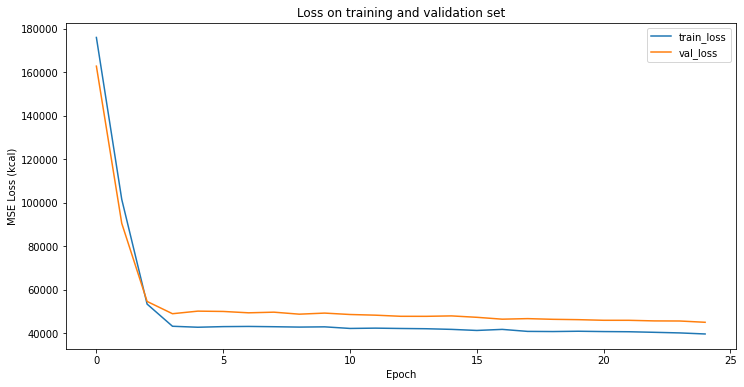

In [5]:
# imagenet preprocessing

import matplotlib.pyplot as plt

history = history.history

plt.figure(figsize=(12,6))
plt.plot(history['loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')

plt.title("Loss on training and validation set")
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (kcal)')
plt.legend()